# University of Aberdeen

## Applied AI (CS5079)

### Assessment 1 Task 1 - Reinforcement Learning from the Screen Frames

---


## Imports

In [ ]:
# OpenAI has preprocessing modules in their baselines repository 
# such as FrameStack, NoopResetEnv, episode_life, etc.
# To import those we first need to install the OpenAI baseline package
# via running this code cell.
!pip install git+https://github.com/openai/baselines.git

In [2]:
# Seed value used for achieving reproducibility
SEED_VALUE = 1337

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
# For handling files
import os
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISM'] = '1'
os.environ['PYTHONHASHSEED'] = str(SEED_VALUE)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(SEED_VALUE)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(SEED_VALUE)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(SEED_VALUE)

# https://github.com/openai/baselines
from baselines.common.atari_wrappers import make_atari, wrap_deepmind, NoopResetEnv, FrameStack

# For plotting graphs
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# OpenAI Gym
import gym

# The frame stack size
FRAME_STACK_SIZE = 5

# Maximum NOOP frame number
NOOP_FRAMES = 10

# Make the Atari game and its environment assign it to
# a variable for later use (RL of the DDQN agent).
env = gym.make("Asterix-v0")

# Wrap the environment using the NoopResetEnv class.
# This ensures that during first n frames in the [0, NOOP_FRAMES] range
# our DDQN agent does no opperations (no actions undertaken).
env = NoopResetEnv(env, noop_max=NOOP_FRAMES)

# Preprocess the environment (downsampling to 84x84 and
# scaling the input image pixels of the game)
env = wrap_deepmind(env, frame_stack=False, scale=True, clip_rewards=False, episode_life=False)

# Stack the input image frames by FRAME_STACK_SIZE
env = FrameStack(env, FRAME_STACK_SIZE)

# Seed the Atari game environment
env.seed(SEED_VALUE)

[1337, 17452119]

## Task 1.1

In [3]:
# Print the observation and action spaces, and the Atari 
# game action space and their names (meanings)
print("Observation space:", env.observation_space)
print("Action space:", env.action_space)
print("Possible actions:", env.unwrapped.get_action_meanings())
# print('Info dictionary:', env.step(action)[3])
# print('Reward:', env.step(action)[1])

Observation space: Box(84, 84, 5)
Action space: Discrete(9)
Possible actions: ['NOOP', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'UPRIGHT', 'UPLEFT', 'DOWNRIGHT', 'DOWNLEFT']


To display this, a simple agent that performs random actions for one episode is implemented.

- **Observations**: `env.observation_space` shows that the obseravtion space is an RGB image of which is an array of shape $(210, 160, 3)$, indicating a height of $210$ pixels, a width of $160$ pixels and $3$ channels.


- **Action Space**: `env.action_space` shows us that the action space is *discrete* with $9$ possible actions that are printed out for better understanding using `env.unwrapped.get_action_meanings()`. Each action is performed repeatedly for a duration of $k$ frames, where $k$ is sampled from the set ${2,3,4}$ uniformly. The discrete space allows for a fixed range of non-negative numbers, where low (`env.observation_space.low`) will be a grid filled with zeros $(0\times0\times0)$ and high (`env.observation_space.high`) will be a grid filled with $250\times250\times250$.


- **Reward**: $0$ but is accumulated as an episode is played and the player collects cauldrons and items giving him points. 


- **Environment's info dictionary**: The info dictionary contains `ale.lives()` which refers to the number of lives left. In our case, the player has only $3$ lives that decrease as he collides with the lyres.


- **Episode**: An episode is concluded when the player loses a life. When a game is played and `done=True`, this indicates that the game is finished and the player has lost all lives. 




## Task 1.2

Please refer to the report for this task.

## Task 1.3

We are using a special wrapper for the purpose of environment preprocessing. 

This reshapes the image to .... and the agent will receive a grayscale observation as we have converted the observarions to grayscale. We also scale all observations to `[0,1]`.

Another common preprocessing step is the introductioon of frame skipping (Naddaf, 2010 at https://era.library.ualberta.ca/items/a661eb66-f2e0-4ed3-b501-b6cbcd1fdd9d), which is what restricts the agent's decision points by repeating some selected action for $k$ consequitve frames, making the RL problem simpler and speeding up execution. 

This notebook follows an approach where the agent is designed with a richer observation space by combining past frames with most recent ones as known as frame stacking (Mnih et al., 2015 https://www.nature.com/articles/nature14236). We use $5$ frames, but the algorithm might also be robust with different values such as 3 or 4. This research experimented with all 3 options and concluded that the use of 5 images in a stack is the most beneficial approach with regards to total reward. Due to this reduction in partial observability, the agent can detect the direction of motion of in-game objects.




(84, 84, 5)


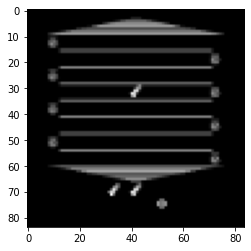

In [4]:
# Print the game image shape and plot a sample 
# image for illustration purposes
obs = env.reset()
print(env.observation_space.shape)
plt.imshow(obs[:,:,0], cmap='gray')
plt.show()

Please refer to the report for a more indepth explanation.

## Task 1.4

read this to check architecture and fig

https://www.nature.com/articles/nature14236

ARCHITECTURE
TODO:

The first hidden layer convolves 32 filters of 8 × 8 with stride 4 with the input image and applies a rectifier nonlinearity 31,32. The second hidden layer convolves 64 filters of 4 × 4 with stride 2, again followed by a rectifier nonlinearity. This is followed by a third convolutional layer that convolves 64 filters of 3 × 3 with stride 1 followed by a rectifier. The final two hidden layers are fully-connected and consist of 512 and 256 rectifier units respectively. The output layer is a fully-connected linear layer with a single output for each valid action. The number of valid actions varied between 4 and 18 on the games we considered.

In [5]:
# Import the garbage collector package
import gc

def reset_random_seeds():
    """Reset the random number generator seed to achieve full reproducibility 
    even when running the script on GPU
    """
    
    # Set the environment determinism to guarantee
    # reproducibility of the results
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISM'] = '1'
    os.environ['PYTHONHASHSEED']=str(SEED_VALUE)
    tf.random.set_seed(SEED_VALUE)
    np.random.seed(SEED_VALUE)
    random.seed(SEED_VALUE)
    
    # Perform garbage collection
    gc.collect()
    print("Random number generator seed reset!")  # optional

### Defining global variable and importing packages for training the models

In [6]:
# Import the Keras layer used for building our DDQN models
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D,\
MaxPool2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import HeUniform

# Get the input shape for the DDQN models (game environment observation space)
INPUT_SHAPE = env.observation_space.shape

# Get the output shape for the DDQN models
NUM_ACTIONS = env.action_space.n

# Set the batch size
BATCH_SIZE = 32

# Set the DDQN agent memory size.
# We use a relatively small value due to assessment time constraints
# and also to provide easier reproducibility. ===================================
MEMORY_SIZE = 25000

# Define the exploration steps of the DDQN agent.
# We do not train the model during these first steps.
EXPLORATION_STEPS = 20000

# Define the learning rate to be used for the model
# gradient descent optimisation method (Adam as opposed to RMSprop) WHY ADAM??===============================
LEARNING_RATE = 0.00025

In [7]:
class SumTree:
    """Code is adapted from an open-source MIT-licensed GitHub repository.
    It implements an optimisation experience replay memory technique that can
    be used for all Atari games DQNs. 
    
    Source: https://github.com/rlcode/per
    Args:
        capacity (int): size of the sum tree
    """
    # The data pointer class variable
    write = 0

    def __init__(self, capacity):
        """Initialize the tree with all nodes and data with values set to 0.
        """
        # Number of leaf nodes (final nodes) that contains experiences
        self.capacity = capacity
        
        # Generate the tree with all nodes values = 0
        # To understand this calculation (2 * capacity - 1) look at the schema above
        # Remember we are in a binary node (each node has max 2 children) so 2x size of leaf (capacity) - 1 (root node)
        # Parent nodes = capacity - 1
        # Leaf nodes = capacity
        self.tree = np.zeros(2 * capacity - 1)
        
        # Store the experiences (so the size of data is capacity)
        self.data = np.zeros(capacity, dtype=object)

    def _propagate(self, idx, change):
        """Recursively propagate a given child node change through the sum tree.
        """
        
        # Get the parent node index
        parent = (idx - 1) // 2
        
        # Apply the child node change to the parent node
        self.tree[parent] += change
        
        # Do this until the root node is reached
        if parent != 0:
            self._propagate(parent, change)

    def _retrieve(self, idx, s):
        """Return a leaf node (priority) index for the current experience (observation)
        """
        
        # Get the left and right child node indexes
        # for the current sample
        left = 2 * idx + 1
        right = left + 1
        
        # Return the index itself if the 
        # left child index is greater than the 
        # capacity of the sum tree
        if left >= len(self.tree):
            return idx
        
        # Start recursion
        if s <= self.tree[left]:
            return self._retrieve(left, s)
        else:
            return self._retrieve(right, s - self.tree[left])

    def total(self):
        """Return the root node (total sum of the experience priority values).
        """
        return self.tree[0]

    def add(self, p, data):
        """Add the experience and its priority score (as a leaf) to the sum tree.
        """
        # Get the tree index for the experience (observation)
        idx = self.write + self.capacity - 1
        
        # Update the sum tree data
        self.data[self.write] = data
        
        # Update the sum tree probability values
        self.update(idx, p)
        
        # Increment the data pointer
        self.write += 1
        
        # If over the capacity, go back to first index (we overwrite)
        if self.write >= self.capacity:
            self.write = 0

    def update(self, idx, p):
        """Update the leaf priority score and propagate the change through tree.
        """
        # Change = new priority score - former priority score
        change = p - self.tree[idx]
        self.tree[idx] = p
        
        # Propagate the change through tree
        self._propagate(idx, change)

    def get(self, s):
        """Return the leaf index, priority value and its associated experience (observation).
        """
        # Get the leaf index
        idx = self._retrieve(0, s)
        
        # Get the experience (observation) index
        dataIdx = idx - self.capacity + 1

        return (idx, self.tree[idx], self.data[dataIdx])
    

#-------------------- MEMORY --------------------------
class Memory:
    """Code is adapted from an open-source MIT-licensed GitHub repository.
    It implements an optimisation experience replay memory technique that can
    be used for all Atari games DQNs. 
    
    Source: https://github.com/rlcode/per
    
    Args:
        capacity (int): size of the sum tree
    """
    # Hyperparameter to avoid assigning 0 probability to experiences
    e = 0.01
    
    # Hyperparameter to make a trade-off between random sampling and taking a
    # a high priority experience (observation)
    a = 0.6

    def __init__(self, capacity):
        """Initialise the sum tree with the given capacity.
        """
        self.tree = SumTree(capacity)

    def _getPriority(self, error):
        return (error + self.e) ** self.a

    def add(self, error, sample):
        """Store a new experience in the tree along with its corresponding priority value.
        """
        # Get the priority from the experience (observation) error
        p = self._getPriority(error)
        
        # Store the priority and the experience (observation)
        self.tree.add(p, sample) 

    def sample(self, n):
        """Sample a n-sized batch of priority index and observation pair.
        """
        # Create a list to hold the batch pairs
        batch = []
        
        # Calculate and store the priority segment
        segment = self.tree.total() / n
        
        # Populate the batch list
        for i in range(n):
            a = segment * i
            b = segment * (i + 1)

            s = random.uniform(a, b)
            (idx, p, data) = self.tree.get(s)
            batch.append( (idx, data) )

        return batch

    def update(self, idx, error):
        """Update the sum tree leaves (priorities).
        """
        # Get the priority from the experience (observation) error
        p = self._getPriority(error)
        
        # Update the sum tree probability values
        self.tree.update(idx, p)

In [26]:
# Import the math Python package
import math

# Minimum and maximum epsilon value constants
MAX_EPSILON = 1
MIN_EPSILON = 0.1

# Constant that determines the speed of the epsilon decay
LAMBDA = - math.log(0.01) / EXPLORATION_STEPS 

class DDQNAgent():
    """Code is adapted from an open-source MIT-licensed GitHub repository.
    It implements an DDQ Network and Agent experience replay memory technique that can
    be used for all Atari games DQNs. 
    
    Source: https://github.com/jaromiru/AI-blog
    
    Args:
        env (AtariEnv): the environment that RLNetwork and Agent are optimized on
        lr (float): learning rate of the network
    """
    steps = 0
    
    def __init__(self, env, lr=LEARNING_RATE):
        """Initialise the agent and the online and target DDQNs for the environment.
        """
        self.lr = lr
        
        self.memory = Memory(MEMORY_SIZE)
        
        # Set the initial DDQN models loss value to be +inf
        self.loss_val = np.inf
        self.action_space = NUM_ACTIONS
        
        # Disable eager execution which boosts runtime
        # Eager execution is generally used for debugging purposes
        tf.compat.v1.disable_eager_execution()
        self.discount_rate = 0.99

        # Create the two networks for predicting the actions
        
        # The first model makes the predictions for Q-values 
        # which are used to make a action.
        self.online = self.q_network()
        
        # Build a target model for the prediction of future
        # rewards. The weights of a target model get updated 
        # every 10,000 steps thus when the loss between the 
        # Q-values is calculated the target Q-value is stable.
        self.target = self.q_network()

        #The "target" DNN will take the values of the "online" DNN
        self.update_target()


    def q_network(self, filters_1=32, filters_2=64, filters_3=64):
        """Define and return the CNN model architecture.
        """
        # Ensure reproducibility of the results
        # by resetting the random seeds
        reset_random_seeds()

        # Build the model
        kernel_init = HeUniform()
        model = Sequential()
        model.add(Conv2D(filters_1, kernel_size=8, padding="same", strides=4, activation='relu', input_shape=INPUT_SHAPE, kernel_initializer=kernel_init))
        model.add(Conv2D(filters_2, kernel_size=4, padding="same", strides=2, activation='relu', kernel_initializer=kernel_init))
        model.add(Conv2D(filters_3, kernel_size=3, padding="same", strides=1, activation='relu', kernel_initializer=kernel_init))
        model.add(Flatten())
        model.add(Dense(512, activation='relu', kernel_initializer=kernel_init))
        model.add(Dense(256, activation='relu', kernel_initializer=kernel_init))
        model.add(Dense(NUM_ACTIONS, activation="linear", kernel_initializer=kernel_init))
        
        # In the Deepmind paper they use RMSProp however then Adam optimizer
        # improves training time
        model.compile(loss="huber_loss", optimizer=Adam(learning_rate=self.lr))
        return model
            
    def update_target(self):
        """Update the target network with the online network weights.
        """
        # Get the online DQN weights
        online_weights = self.online.get_weights()
        
        # Update the target DQN weights
        self.target.set_weights(online_weights)
        
    #---- CHOSSING ACTION ----
    def get_action(self, state, step):
        """Based on the Epsilon agent chooses wheter to explore or exploatate
        """
        if step <= EXPLORATION_STEPS:
            return np.random.randint(self.action_space)
        else:     
            self.steps += 1
            epsilon = MIN_EPSILON + (MAX_EPSILON - MIN_EPSILON) * math.exp(-LAMBDA * self.steps)
            if np.random.rand() < epsilon:
                return np.random.randint(self.action_space)# random action
            else:
                q_values = self.online.predict(state.reshape(-1, *INPUT_SHAPE))
                return np.argmax(q_values) # optimal action
    
    def get_train_data(self, batch):
        """Decide on the input, desired output and error of the current state.
        """
        
        # NumPy array storing no observation space
        # used at the end of each episode (improved performance)
        no_state = np.zeros(INPUT_SHAPE)
        
        # Get the previous states from the batch observations
        prev_states = np.array([obs[1][0] for obs in batch])
        
        # Get the next states from the batch observations
        # No state if done = True
        next_states = np.array([(no_state if obs[1][4] is True else obs[1][3]) for obs in batch])
        
        # Make predictions based on the previous states
        # using the online model
        prev_q_vals = self.online.predict(prev_states)
        
        # Make predictions based on the next states
        # using the online model (used in the function for 
        # calculating the future q values of the DDQN)
        next_q_vals_double = self.online.predict(next_states)
        
        # Make predictions based on the next states
        # using the target model
        next_q_vals = self.target.predict(next_states)
        
        # Create NumPy arrays for storing the previous states and future q values,
        # and the calculated error values (used for determining state priorities)
        # respectively
        X = np.zeros((len(batch), *INPUT_SHAPE))
        Y = np.zeros((len(batch), NUM_ACTIONS))
        errors = np.zeros(len(batch))
        
        for idx in range(len(batch)):
            
            # Unpack the current batch sample
            curr_state, action, reward, next_state, done = batch[idx][1]
            
            # Get the current (previous/old) state q value
            q_val = prev_q_vals[idx]
            prev_q_val = q_val[action]
            
            # Future q value is the current q val
            # which is to be updated using the predictions of
            # both the online and the target models
            future_q_val = q_val
            
            # Update the future q value
            if done:
                future_q_val[action] = reward
            else:
                future_q_val[action] = reward + next_q_vals[idx][np.argmax(next_q_vals_double[idx])] * self.discount_rate
            
            # Populate the previous state and future q value lists 
            X[idx] = curr_state
            Y[idx] = future_q_val
            
            # Calculate the error values for each experience (observation)
            errors[idx] = abs(prev_q_val - future_q_val[action])
        
        return (X, Y, errors)
    
    def save_to_memory(self, curr_state, action, reward, next_state, done, step):
        """Update the sum tree priorities and observations (samples).
        """
        sample = (curr_state, action, reward, next_state, done)
        if step <= EXPLORATION_STEPS:
            error = abs(sample[2])  # Reward
            self.memory.add(error, sample)
        else:
            X, Y, errors = self.get_train_data([(0, sample)])
            self.memory.add(errors[0], sample)
        
    def train(self, step):
        """Train the online model and update the loss value.
        """
        
        # Sample a batch error-observation pairs
        batch = self.memory.sample(BATCH_SIZE)
        X, Y, errors = self.get_train_data(batch)
        
        # Update errors
        for i in range(len(batch)):
            idx = batch[i][0]
            self.memory.update(idx, errors[i])
        
        # Fit the online DDQN and update the loss value
        hist = self.online.fit(X, Y, batch_size=BATCH_SIZE, epochs=1, verbose=0, shuffle=True)
        self.loss_val = hist.history['loss'][0]
    


Please refer to the report for further information regarding the deployment and parameter adjustments of the agent.

## Task 1.5

In [9]:
import time

# Initialise the DDQN agent 
ddqn_agent = DDQNAgent(env)  

# Lists to hold the steps and their corresponding rewards respectively 
ep_steps, ep_rewards = [], []

# To hold the total episode reward of the agent
total_reward = 0

# Total number of training steps
N_STEPS = 1000000  

# Train the model after 4 actions
TRAIN_ONLINE_STEPS = 4

# Update teh target every 10,000 steps (1 epoch)
# Considered as a hyperparameter
UPDATE_TARGET_STEPS = 10000

# Start the DDQN agent game exploration and training loop
done=True
for step in range(N_STEPS):
    
    # Calculate the DDQN agent training process
    # completion as percentage
    total_perc = step * 100 / N_STEPS
    
    # Print the current step, total number of training steps, training process percentage and DDQN loss value
    print(f"\r\tAction step: {step}/{N_STEPS} ({total_perc:.2f}%)\tLoss: {ddqn_agent.loss_val:5f}", end="")
    
    # Reset the game environment once the ddqn_agent
    # is out of lives
    if done:
        
        # Calculate the average reward for the episode (for 3 lives)
        avg_reward = int(total_reward/3)
        
        # Append the total reward and episode steps
        # used later for plotting and printing
        if step:
            ep_rewards.append(total_reward)
            ep_steps.append(step)
        
        # Print the most recent average (mean) episode and total (all episodes so far) reward values 
        print(f"\tAVG reward: {avg_reward}\tTotal mean: {np.mean(ep_rewards)}")
        
        # Reset the game environment and get the initial observation
        obs = env.reset()
        
        # Conver the observation to NumPy array
        # since we need such arrays to carry out the ddqn_agent training
        state = np.array(obs)
        
        # Reset the total episode reward since
        # we start a new episode
        total_reward = 0


    # Get a exploration/exploitation action
    action = ddqn_agent.get_action(state, step)

    # Take a step in the game environment
    next_state, reward, done, info = env.step(action)
    
    # Convert to NumPy array
    next_state = np.array(next_state)
    
    # Update the sum tree priorities and observations (samples)
    ddqn_agent.save_to_memory(state, action, reward, next_state, done, step)
    
    # Skip training the DDQN agent if still exploring
    if step > EXPLORATION_STEPS:
        
        # Train the online DDQN every 4th frame
        if step % TRAIN_ONLINE_STEPS == 0:
            ddqn_agent.train(step)

        # Regularly (every 10000 steps) copy the online DDQN to the target DDQN
        if step % UPDATE_TARGET_STEPS == 0:
            ddqn_agent.update_target()
    
    # Render the game environment
#     env.render()
    
    # Increment the total reward by the current reward
    total_reward += reward
    state = next_state

# Close the game environment 
env.close()

Random number generator seed reset!
Random number generator seed reset!
	Action step: 0/1000000 (0.00%)	Loss:   inf	AVG reward: 0	Total mean: nan
	Action step: 261/1000000 (0.03%)	Loss:   inf

c:\program files\python38\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\program files\python38\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


	Action step: 543/1000000 (0.05%)	Loss:   inf	AVG reward: 183	Total mean: 550.0


	Action step: 875/1000000 (0.09%)	Loss:   inf

	Action step: 927/1000000 (0.09%)	Loss:   inf	AVG reward: 133	Total mean: 475.0
	Action step: 1315/1000000 (0.13%)	Loss:   inf	AVG reward: 83	Total mean: 400.0
	Action step: 1630/1000000 (0.16%)	Loss:   inf	AVG reward: 66	Total mean: 350.0
	Action step: 1996/1000000 (0.20%)	Loss:   inf	AVG reward: 116	Total mean: 350.0
	Action step: 2427/1000000 (0.24%)	Loss:   inf	AVG reward: 133	Total mean: 358.3333333333333
	Action step: 2763/1000000 (0.28%)	Loss:   inf	AVG reward: 116	Total mean: 357.14285714285717
	Action step: 3150/1000000 (0.32%)	Loss:   inf	AVG reward: 100	Total mean: 350.0
	Action step: 3414/1000000 (0.34%)	Loss:   inf	AVG reward: 50	Total mean: 327.77777777777777
	Action step: 3694/1000000 (0.37%)	Loss:   inf	AVG reward: 33	Total mean: 305.0
	Action step: 4012/1000000 (0.40%)	Loss:   inf	AVG reward: 83	Total mean: 300.0
	Action step: 4312/1000000 (0.43%)	Loss:   inf	AVG reward: 83	Total mean: 295.8333333333333
	Action step: 4593/1000000 (0.46%)	Loss:   inf	AVG reward: 0	Total

c:\program files\python38\lib\site-packages\keras\engine\training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


	Action step: 20004/1000000 (2.00%)	Loss:   inf	AVG reward: 33	Total mean: 283.92857142857144
	Action step: 20416/1000000 (2.04%)	Loss: 3.373157	AVG reward: 116	Total mean: 285.0877192982456
	Action step: 20697/1000000 (2.07%)	Loss: 2.376032	AVG reward: 16	Total mean: 281.0344827586207
	Action step: 21113/1000000 (2.11%)	Loss: 1.555828	AVG reward: 100	Total mean: 281.35593220338984
	Action step: 21471/1000000 (2.15%)	Loss: 2.463397	AVG reward: 183	Total mean: 285.8333333333333
	Action step: 21776/1000000 (2.18%)	Loss: 1.801031	AVG reward: 66	Total mean: 284.42622950819674
	Action step: 22179/1000000 (2.22%)	Loss: 1.460757	AVG reward: 133	Total mean: 286.2903225806452
	Action step: 22444/1000000 (2.24%)	Loss: 1.567810	AVG reward: 33	Total mean: 283.3333333333333
	Action step: 22854/1000000 (2.29%)	Loss: 1.408937	AVG reward: 116	Total mean: 284.375
	Action step: 23265/1000000 (2.33%)	Loss: 1.424379	AVG reward: 83	Total mean: 283.84615384615387
	Action step: 23575/1000000 (2.36%)	Loss: 1.

	Action step: 78350/1000000 (7.83%)	Loss: 0.413632	AVG reward: 116	Total mean: 286.72566371681415
	Action step: 78908/1000000 (7.89%)	Loss: 0.339005	AVG reward: 200	Total mean: 288.1057268722467
	Action step: 79255/1000000 (7.93%)	Loss: 0.173784	AVG reward: 100	Total mean: 288.1578947368421
	Action step: 79781/1000000 (7.98%)	Loss: 0.391402	AVG reward: 250	Total mean: 290.174672489083
	Action step: 80129/1000000 (8.01%)	Loss: 0.449409	AVG reward: 116	Total mean: 290.4347826086956
	Action step: 80421/1000000 (8.04%)	Loss: 0.411042	AVG reward: 116	Total mean: 290.6926406926407
	Action step: 80788/1000000 (8.08%)	Loss: 0.909947	AVG reward: 150	Total mean: 291.37931034482756
	Action step: 81053/1000000 (8.11%)	Loss: 0.604056	AVG reward: 66	Total mean: 290.9871244635193
	Action step: 81342/1000000 (8.13%)	Loss: 0.328257	AVG reward: 100	Total mean: 291.02564102564105
	Action step: 81623/1000000 (8.16%)	Loss: 0.376301	AVG reward: 66	Total mean: 290.63829787234044
	Action step: 81941/1000000 (

	Action step: 137180/1000000 (13.72%)	Loss: 0.616331	AVG reward: 150	Total mean: 320.99236641221376
	Action step: 137412/1000000 (13.74%)	Loss: 0.305969	AVG reward: 66	Total mean: 320.6852791878173
	Action step: 137715/1000000 (13.77%)	Loss: 0.308576	AVG reward: 100	Total mean: 320.63291139240505
	Action step: 137990/1000000 (13.80%)	Loss: 0.344396	AVG reward: 83	Total mean: 320.45454545454544
	Action step: 138235/1000000 (13.82%)	Loss: 0.366521	AVG reward: 116	Total mean: 320.5289672544081
	Action step: 138906/1000000 (13.89%)	Loss: 0.214973	AVG reward: 200	Total mean: 321.23115577889445
	Action step: 139209/1000000 (13.92%)	Loss: 0.368341	AVG reward: 66	Total mean: 320.9273182957393
	Action step: 139651/1000000 (13.97%)	Loss: 0.552889	AVG reward: 183	Total mean: 321.5
	Action step: 140099/1000000 (14.01%)	Loss: 0.385755	AVG reward: 183	Total mean: 322.06982543640896
	Action step: 140420/1000000 (14.04%)	Loss: 0.393072	AVG reward: 83	Total mean: 321.8905472636816
	Action step: 140648/

	Action step: 168974/1000000 (16.90%)	Loss: 0.338064	AVG reward: 116	Total mean: 337.60504201680675
	Action step: 169244/1000000 (16.92%)	Loss: 0.613272	AVG reward: 116	Total mean: 337.6310272536688
	Action step: 169631/1000000 (16.96%)	Loss: 0.587338	AVG reward: 116	Total mean: 337.6569037656904
	Action step: 169984/1000000 (17.00%)	Loss: 0.666445	AVG reward: 100	Total mean: 337.5782881002088
	Action step: 170570/1000000 (17.06%)	Loss: 0.900771	AVG reward: 283	Total mean: 338.6458333333333
	Action step: 170856/1000000 (17.09%)	Loss: 0.893486	AVG reward: 116	Total mean: 338.66943866943865
	Action step: 171092/1000000 (17.11%)	Loss: 0.648954	AVG reward: 133	Total mean: 338.7966804979253
	Action step: 171427/1000000 (17.14%)	Loss: 0.736251	AVG reward: 116	Total mean: 338.8198757763975
	Action step: 171844/1000000 (17.18%)	Loss: 0.732784	AVG reward: 183	Total mean: 339.25619834710744
	Action step: 172110/1000000 (17.21%)	Loss: 0.974605	AVG reward: 100	Total mean: 339.17525773195877
	Actio

	Action step: 200559/1000000 (20.06%)	Loss: 0.500982	AVG reward: 150	Total mean: 351.61001788908766
	Action step: 200831/1000000 (20.08%)	Loss: 0.602357	AVG reward: 83	Total mean: 351.42857142857144
	Action step: 201203/1000000 (20.12%)	Loss: 0.765781	AVG reward: 166	Total mean: 351.6934046345811
	Action step: 201490/1000000 (20.15%)	Loss: 0.586645	AVG reward: 116	Total mean: 351.69039145907476
	Action step: 201769/1000000 (20.18%)	Loss: 0.633883	AVG reward: 66	Total mean: 351.4209591474245
	Action step: 202101/1000000 (20.21%)	Loss: 0.655832	AVG reward: 66	Total mean: 351.15248226950354
	Action step: 202373/1000000 (20.24%)	Loss: 0.416359	AVG reward: 50	Total mean: 350.79646017699116
	Action step: 202773/1000000 (20.28%)	Loss: 0.614648	AVG reward: 133	Total mean: 350.88339222614843
	Action step: 203158/1000000 (20.32%)	Loss: 1.100452	AVG reward: 150	Total mean: 351.05820105820106
	Action step: 203427/1000000 (20.34%)	Loss: 0.864347	AVG reward: 100	Total mean: 350.96830985915494
	Actio

	Action step: 264809/1000000 (26.48%)	Loss: 0.589810	AVG reward: 50	Total mean: 370.6896551724138
	Action step: 265382/1000000 (26.54%)	Loss: 0.793612	AVG reward: 233	Total mean: 371.1432506887052
	Action step: 265747/1000000 (26.57%)	Loss: 0.586742	AVG reward: 150	Total mean: 371.25171939477303
	Action step: 266239/1000000 (26.62%)	Loss: 0.665710	AVG reward: 183	Total mean: 371.49725274725273
	Action step: 266830/1000000 (26.68%)	Loss: 0.485263	AVG reward: 166	Total mean: 371.67352537722905
	Action step: 267110/1000000 (26.71%)	Loss: 0.382451	AVG reward: 50	Total mean: 371.36986301369865
	Action step: 267377/1000000 (26.74%)	Loss: 0.414811	AVG reward: 83	Total mean: 371.20383036935704
	Action step: 267597/1000000 (26.76%)	Loss: 0.713281	AVG reward: 50	Total mean: 370.9016393442623
	Action step: 267874/1000000 (26.79%)	Loss: 0.436243	AVG reward: 100	Total mean: 370.8049113233288
	Action step: 268433/1000000 (26.84%)	Loss: 0.739927	AVG reward: 200	Total mean: 371.1171662125341
	Action s

	Action step: 296705/1000000 (29.67%)	Loss: 0.624338	AVG reward: 133	Total mean: 374.5049504950495
	Action step: 297044/1000000 (29.70%)	Loss: 0.326277	AVG reward: 100	Total mean: 374.41285537700867
	Action step: 297436/1000000 (29.74%)	Loss: 0.462228	AVG reward: 83	Total mean: 374.25925925925924
	Action step: 297748/1000000 (29.77%)	Loss: 0.715870	AVG reward: 100	Total mean: 374.1676942046856
	Action step: 298204/1000000 (29.82%)	Loss: 0.590715	AVG reward: 183	Total mean: 374.384236453202
	Action step: 298473/1000000 (29.85%)	Loss: 0.321620	AVG reward: 66	Total mean: 374.16974169741695
	Action step: 298810/1000000 (29.88%)	Loss: 0.398671	AVG reward: 133	Total mean: 374.2014742014742
	Action step: 299238/1000000 (29.92%)	Loss: 0.268888	AVG reward: 116	Total mean: 374.1717791411043
	Action step: 299774/1000000 (29.98%)	Loss: 0.337688	AVG reward: 250	Total mean: 374.63235294117646
	Action step: 300184/1000000 (30.02%)	Loss: 0.539171	AVG reward: 200	Total mean: 374.90820073439414
	Action 

	Action step: 329602/1000000 (32.96%)	Loss: 0.291698	AVG reward: 150	Total mean: 380.13468013468014
	Action step: 330043/1000000 (33.00%)	Loss: 0.830513	AVG reward: 116	Total mean: 380.10089686098655
	Action step: 330731/1000000 (33.07%)	Loss: 0.687095	AVG reward: 266	Total mean: 380.5711086226204
	Action step: 331009/1000000 (33.10%)	Loss: 0.553863	AVG reward: 83	Total mean: 380.4250559284116
	Action step: 331366/1000000 (33.14%)	Loss: 0.475741	AVG reward: 133	Total mean: 380.44692737430165
	Action step: 331721/1000000 (33.17%)	Loss: 0.440097	AVG reward: 133	Total mean: 380.46875
	Action step: 331972/1000000 (33.20%)	Loss: 0.829944	AVG reward: 83	Total mean: 380.3232998885173
	Action step: 332416/1000000 (33.24%)	Loss: 0.364873	AVG reward: 183	Total mean: 380.5122494432071
	Action step: 332868/1000000 (33.29%)	Loss: 0.595044	AVG reward: 200	Total mean: 380.75639599555063
	Action step: 333214/1000000 (33.32%)	Loss: 0.526643	AVG reward: 133	Total mean: 380.77777777777777
	Action step: 3

	Action step: 362726/1000000 (36.27%)	Loss: 0.814329	AVG reward: 183	Total mean: 384.4969199178645
	Action step: 363085/1000000 (36.31%)	Loss: 0.344175	AVG reward: 133	Total mean: 384.5128205128205
	Action step: 363570/1000000 (36.36%)	Loss: 0.697096	AVG reward: 200	Total mean: 384.7336065573771
	Action step: 363967/1000000 (36.40%)	Loss: 0.309184	AVG reward: 116	Total mean: 384.6980552712385
	Action step: 364278/1000000 (36.43%)	Loss: 0.284899	AVG reward: 116	Total mean: 384.66257668711654
	Action step: 364616/1000000 (36.46%)	Loss: 0.542321	AVG reward: 116	Total mean: 384.62717058222677
	Action step: 365061/1000000 (36.51%)	Loss: 0.544020	AVG reward: 166	Total mean: 384.7448979591837
	Action step: 365467/1000000 (36.55%)	Loss: 0.382855	AVG reward: 200	Total mean: 384.96432212028543
	Action step: 365809/1000000 (36.58%)	Loss: 0.749316	AVG reward: 116	Total mean: 384.928716904277
	Action step: 366119/1000000 (36.61%)	Loss: 0.296295	AVG reward: 116	Total mean: 384.8931841302136
	Action 

	Action step: 394325/1000000 (39.43%)	Loss: 0.461402	AVG reward: 216	Total mean: 388.0794701986755
	Action step: 394791/1000000 (39.48%)	Loss: 0.691572	AVG reward: 233	Total mean: 388.3742911153119
	Action step: 395246/1000000 (39.52%)	Loss: 0.416684	AVG reward: 150	Total mean: 388.4324834749764
	Action step: 395549/1000000 (39.55%)	Loss: 0.520298	AVG reward: 50	Total mean: 388.20754716981133
	Action step: 395820/1000000 (39.58%)	Loss: 0.419295	AVG reward: 16	Total mean: 387.88878416588125
	Action step: 396524/1000000 (39.65%)	Loss: 0.321898	AVG reward: 316	Total mean: 388.4180790960452
	Action step: 396886/1000000 (39.69%)	Loss: 0.493925	AVG reward: 133	Total mean: 388.42897460018816
	Action step: 397141/1000000 (39.71%)	Loss: 0.464777	AVG reward: 66	Total mean: 388.2518796992481
	Action step: 397484/1000000 (39.75%)	Loss: 0.632882	AVG reward: 116	Total mean: 388.21596244131456
	Action step: 397866/1000000 (39.79%)	Loss: 0.315476	AVG reward: 200	Total mean: 388.4146341463415
	Action s

	Action step: 426687/1000000 (42.67%)	Loss: 0.347205	AVG reward: 83	Total mean: 391.7543859649123
	Action step: 426980/1000000 (42.70%)	Loss: 0.725657	AVG reward: 116	Total mean: 391.7177914110429
	Action step: 427376/1000000 (42.74%)	Loss: 0.538148	AVG reward: 150	Total mean: 391.76882661996495
	Action step: 427642/1000000 (42.76%)	Loss: 0.708663	AVG reward: 116	Total mean: 391.73228346456693
	Action step: 428096/1000000 (42.81%)	Loss: 0.550423	AVG reward: 150	Total mean: 391.7832167832168
	Action step: 428626/1000000 (42.86%)	Loss: 0.319241	AVG reward: 233	Total mean: 392.0524017467249
	Action step: 429121/1000000 (42.91%)	Loss: 0.305084	AVG reward: 150	Total mean: 392.10296684118674
	Action step: 429601/1000000 (42.96%)	Loss: 0.381963	AVG reward: 216	Total mean: 392.3278116826504
	Action step: 430048/1000000 (43.00%)	Loss: 1.038796	AVG reward: 183	Total mean: 392.46515679442507
	Action step: 430455/1000000 (43.05%)	Loss: 0.643970	AVG reward: 116	Total mean: 392.4281984334204
	Action

	Action step: 459255/1000000 (45.93%)	Loss: 0.600312	AVG reward: 200	Total mean: 394.358135731807
	Action step: 459519/1000000 (45.95%)	Loss: 0.215860	AVG reward: 66	Total mean: 394.19934640522877
	Action step: 459899/1000000 (45.99%)	Loss: 0.349960	AVG reward: 166	Total mean: 394.2857142857143
	Action step: 460250/1000000 (46.02%)	Loss: 1.031797	AVG reward: 133	Total mean: 394.2903752039152
	Action step: 460536/1000000 (46.05%)	Loss: 0.966481	AVG reward: 83	Total mean: 394.17277913610434
	Action step: 460963/1000000 (46.10%)	Loss: 0.521427	AVG reward: 216	Total mean: 394.38110749185665
	Action step: 461351/1000000 (46.14%)	Loss: 0.759230	AVG reward: 150	Total mean: 394.42636289666393
	Action step: 461977/1000000 (46.20%)	Loss: 0.629233	AVG reward: 233	Total mean: 394.6747967479675
	Action step: 462242/1000000 (46.22%)	Loss: 0.390636	AVG reward: 100	Total mean: 394.5978878960195
	Action step: 462503/1000000 (46.25%)	Loss: 0.582614	AVG reward: 100	Total mean: 394.5211038961039
	Action s

	Action step: 492392/1000000 (49.24%)	Loss: 0.666373	AVG reward: 116	Total mean: 397.77947932618684
	Action step: 492747/1000000 (49.27%)	Loss: 0.674934	AVG reward: 100	Total mean: 397.7046671767406
	Action step: 493107/1000000 (49.31%)	Loss: 0.753574	AVG reward: 133	Total mean: 397.70642201834863
	Action step: 493348/1000000 (49.33%)	Loss: 0.322715	AVG reward: 83	Total mean: 397.5935828877005
	Action step: 493962/1000000 (49.40%)	Loss: 0.515665	AVG reward: 183	Total mean: 397.70992366412213
	Action step: 494310/1000000 (49.43%)	Loss: 0.626967	AVG reward: 116	Total mean: 397.673531655225
	Action step: 494696/1000000 (49.47%)	Loss: 0.377093	AVG reward: 150	Total mean: 397.7134146341463
	Action step: 495038/1000000 (49.50%)	Loss: 0.340769	AVG reward: 66	Total mean: 397.56283320639756
	Action step: 495436/1000000 (49.54%)	Loss: 0.464040	AVG reward: 183	Total mean: 397.67884322678844
	Action step: 495940/1000000 (49.59%)	Loss: 0.379043	AVG reward: 200	Total mean: 397.83269961977186
	Action

	Action step: 526626/1000000 (52.66%)	Loss: 0.360243	AVG reward: 183	Total mean: 400.5759539236861
	Action step: 526904/1000000 (52.69%)	Loss: 0.699856	AVG reward: 83	Total mean: 400.46762589928056
	Action step: 527205/1000000 (52.72%)	Loss: 0.347641	AVG reward: 133	Total mean: 400.4672897196262
	Action step: 527512/1000000 (52.75%)	Loss: 0.289268	AVG reward: 83	Total mean: 400.35919540229884
	Action step: 528049/1000000 (52.80%)	Loss: 0.622271	AVG reward: 216	Total mean: 400.53840631730077
	Action step: 528338/1000000 (52.83%)	Loss: 0.447050	AVG reward: 116	Total mean: 400.50215208034433
	Action step: 528689/1000000 (52.87%)	Loss: 0.478428	AVG reward: 166	Total mean: 400.57347670250897
	Action step: 528996/1000000 (52.90%)	Loss: 0.548755	AVG reward: 100	Total mean: 400.50143266475646
	Action step: 529390/1000000 (52.94%)	Loss: 0.581548	AVG reward: 150	Total mean: 400.5368647100931
	Action step: 529746/1000000 (52.97%)	Loss: 0.246016	AVG reward: 133	Total mean: 400.53648068669526
	Acti

	Action step: 594147/1000000 (59.41%)	Loss: 0.288182	AVG reward: 166	Total mean: 408.52638352638354
	Action step: 594596/1000000 (59.46%)	Loss: 0.570637	AVG reward: 200	Total mean: 408.6495176848875
	Action step: 595026/1000000 (59.50%)	Loss: 0.523636	AVG reward: 200	Total mean: 408.7724935732648
	Action step: 595379/1000000 (59.54%)	Loss: 0.210365	AVG reward: 183	Total mean: 408.8631984585742
	Action step: 595609/1000000 (59.56%)	Loss: 0.590108	AVG reward: 100	Total mean: 408.793324775353
	Action step: 596024/1000000 (59.60%)	Loss: 0.350769	AVG reward: 166	Total mean: 408.85182809493267
	Action step: 596430/1000000 (59.64%)	Loss: 0.486355	AVG reward: 216	Total mean: 409.0064102564103
	Action step: 596744/1000000 (59.67%)	Loss: 0.731060	AVG reward: 133	Total mean: 409.0006406149904
	Action step: 597208/1000000 (59.72%)	Loss: 0.396101	AVG reward: 216	Total mean: 409.15492957746477
	Action step: 597419/1000000 (59.74%)	Loss: 0.647012	AVG reward: 100	Total mean: 409.0850927703135
	Action 

	Action step: 626911/1000000 (62.69%)	Loss: 0.692318	AVG reward: 100	Total mean: 410.0794135613928
	Action step: 627196/1000000 (62.72%)	Loss: 0.296701	AVG reward: 83	Total mean: 409.98168498168496
	Action step: 627464/1000000 (62.75%)	Loss: 0.490811	AVG reward: 50	Total mean: 409.8230628431971
	Action step: 627725/1000000 (62.77%)	Loss: 0.329704	AVG reward: 16	Total mean: 409.6036585365854
	Action step: 628076/1000000 (62.81%)	Loss: 0.301269	AVG reward: 100	Total mean: 409.5368677635588
	Action step: 628392/1000000 (62.84%)	Loss: 0.663167	AVG reward: 116	Total mean: 409.5006090133983
	Action step: 628675/1000000 (62.87%)	Loss: 0.590351	AVG reward: 50	Total mean: 409.342665855143
	Action step: 628932/1000000 (62.89%)	Loss: 0.442609	AVG reward: 33	Total mean: 409.154501216545
	Action step: 629210/1000000 (62.92%)	Loss: 0.578652	AVG reward: 83	Total mean: 409.05775075987845
	Action step: 629524/1000000 (62.95%)	Loss: 0.522893	AVG reward: 83	Total mean: 408.96111786148236
	Action step: 62

	Action step: 659109/1000000 (65.91%)	Loss: 0.292276	AVG reward: 16	Total mean: 410.1453488372093
	Action step: 659423/1000000 (65.94%)	Loss: 0.650170	AVG reward: 116	Total mean: 410.11040092969205
	Action step: 659917/1000000 (65.99%)	Loss: 0.701576	AVG reward: 216	Total mean: 410.24970963995355
	Action step: 660249/1000000 (66.02%)	Loss: 0.559684	AVG reward: 166	Total mean: 410.3017991874637
	Action step: 660749/1000000 (66.07%)	Loss: 0.781727	AVG reward: 200	Total mean: 410.41183294663574
	Action step: 661052/1000000 (66.11%)	Loss: 0.542600	AVG reward: 116	Total mean: 410.3768115942029
	Action step: 661456/1000000 (66.15%)	Loss: 0.479654	AVG reward: 216	Total mean: 410.51564310544615
	Action step: 661992/1000000 (66.20%)	Loss: 0.402934	AVG reward: 216	Total mean: 410.6543138390272
	Action step: 662315/1000000 (66.23%)	Loss: 0.572415	AVG reward: 166	Total mean: 410.70601851851853
	Action step: 662745/1000000 (66.27%)	Loss: 0.273498	AVG reward: 183	Total mean: 410.7865818392134
	Actio

	Action step: 726169/1000000 (72.62%)	Loss: 0.249720	AVG reward: 83	Total mean: 414.2440318302387
	Action step: 726484/1000000 (72.65%)	Loss: 0.458912	AVG reward: 116	Total mean: 414.2099681866384
	Action step: 727090/1000000 (72.71%)	Loss: 0.321007	AVG reward: 250	Total mean: 414.3879173290938
	Action step: 727387/1000000 (72.74%)	Loss: 0.633909	AVG reward: 83	Total mean: 414.3008474576271
	Action step: 728036/1000000 (72.80%)	Loss: 0.417885	AVG reward: 250	Total mean: 414.4785600847009
	Action step: 728545/1000000 (72.85%)	Loss: 0.553256	AVG reward: 200	Total mean: 414.5767195767196
	Action step: 728853/1000000 (72.89%)	Loss: 0.465719	AVG reward: 100	Total mean: 414.51612903225805
	Action step: 729293/1000000 (72.93%)	Loss: 0.405625	AVG reward: 166	Total mean: 414.56131078224104
	Action step: 729660/1000000 (72.97%)	Loss: 0.416427	AVG reward: 133	Total mean: 414.55361859482304
	Action step: 730100/1000000 (73.01%)	Loss: 0.746007	AVG reward: 183	Total mean: 414.62513199577614
	Action 

	Action step: 759927/1000000 (75.99%)	Loss: 0.529700	AVG reward: 216	Total mean: 417.6575203252033
	Action step: 760674/1000000 (76.07%)	Loss: 0.986499	AVG reward: 283	Total mean: 417.877094972067
	Action step: 761224/1000000 (76.12%)	Loss: 0.445757	AVG reward: 166	Total mean: 417.9187817258883
	Action step: 761829/1000000 (76.18%)	Loss: 0.574144	AVG reward: 250	Total mean: 418.0872653475393
	Action step: 762058/1000000 (76.21%)	Loss: 0.343525	AVG reward: 66	Total mean: 417.9766734279919
	Action step: 762363/1000000 (76.24%)	Loss: 1.048715	AVG reward: 100	Total mean: 417.9168778509883
	Action step: 762784/1000000 (76.28%)	Loss: 0.666075	AVG reward: 150	Total mean: 417.93313069908817
	Action step: 763355/1000000 (76.34%)	Loss: 0.592971	AVG reward: 283	Total mean: 418.1518987341772
	Action step: 763750/1000000 (76.38%)	Loss: 0.426256	AVG reward: 116	Total mean: 418.1174089068826
	Action step: 764013/1000000 (76.40%)	Loss: 0.438307	AVG reward: 66	Total mean: 418.00708143651997
	Action ste

	Action step: 792427/1000000 (79.24%)	Loss: 1.176810	AVG reward: 166	Total mean: 418.40565577766944
	Action step: 792762/1000000 (79.28%)	Loss: 0.734923	AVG reward: 133	Total mean: 418.3966861598441
	Action step: 793389/1000000 (79.34%)	Loss: 0.569243	AVG reward: 250	Total mean: 418.55820750121774
	Action step: 793746/1000000 (79.37%)	Loss: 0.534544	AVG reward: 133	Total mean: 418.5491723466407
	Action step: 794309/1000000 (79.43%)	Loss: 0.627006	AVG reward: 250	Total mean: 418.71046228710463
	Action step: 794790/1000000 (79.48%)	Loss: 0.849768	AVG reward: 216	Total mean: 418.8229571984436
	Action step: 795149/1000000 (79.51%)	Loss: 0.661022	AVG reward: 133	Total mean: 418.81380651434125
	Action step: 795546/1000000 (79.55%)	Loss: 0.365490	AVG reward: 183	Total mean: 418.8775510204082
	Action step: 795988/1000000 (79.60%)	Loss: 0.484771	AVG reward: 166	Total mean: 418.91694997571636
	Action step: 796486/1000000 (79.65%)	Loss: 0.308252	AVG reward: 250	Total mean: 419.07766990291265
	Act

	Action step: 828098/1000000 (82.81%)	Loss: 0.372233	AVG reward: 50	Total mean: 422.0009372071228
	Action step: 828444/1000000 (82.84%)	Loss: 0.363976	AVG reward: 116	Total mean: 421.9672131147541
	Action step: 828689/1000000 (82.87%)	Loss: 0.407149	AVG reward: 83	Total mean: 421.8867041198502
	Action step: 829086/1000000 (82.91%)	Loss: 0.464483	AVG reward: 133	Total mean: 421.8764623303697
	Action step: 829368/1000000 (82.94%)	Loss: 0.529331	AVG reward: 116	Total mean: 421.8428437792329
	Action step: 829660/1000000 (82.97%)	Loss: 0.370827	AVG reward: 133	Total mean: 421.83263207106125
	Action step: 830030/1000000 (83.00%)	Loss: 0.543792	AVG reward: 150	Total mean: 421.8457943925234
	Action step: 830591/1000000 (83.06%)	Loss: 0.487482	AVG reward: 200	Total mean: 421.9290051377861
	Action step: 830952/1000000 (83.10%)	Loss: 0.492616	AVG reward: 83	Total mean: 421.8487394957983
	Action step: 831243/1000000 (83.12%)	Loss: 1.016174	AVG reward: 50	Total mean: 421.7218852076528
	Action step:

	Action step: 861156/1000000 (86.12%)	Loss: 0.447057	AVG reward: 200	Total mean: 421.9666215606676
	Action step: 861481/1000000 (86.15%)	Loss: 0.718721	AVG reward: 116	Total mean: 421.9341749323715
	Action step: 861865/1000000 (86.19%)	Loss: 0.561893	AVG reward: 100	Total mean: 421.8792248760703
	Action step: 862365/1000000 (86.24%)	Loss: 0.445921	AVG reward: 183	Total mean: 421.93693693693695
	Action step: 862639/1000000 (86.26%)	Loss: 0.717394	AVG reward: 16	Total mean: 421.76947321026563
	Action step: 863027/1000000 (86.30%)	Loss: 0.852490	AVG reward: 133	Total mean: 421.75967596759676
	Action step: 863282/1000000 (86.33%)	Loss: 0.496840	AVG reward: 83	Total mean: 421.6824111560954
	Action step: 863579/1000000 (86.36%)	Loss: 0.632995	AVG reward: 166	Total mean: 421.71762589928056
	Action step: 864111/1000000 (86.41%)	Loss: 0.752741	AVG reward: 233	Total mean: 421.8426966292135
	Action step: 864673/1000000 (86.47%)	Loss: 0.379979	AVG reward: 233	Total mean: 421.9676549865229
	Action 

	Action step: 932603/1000000 (93.26%)	Loss: 0.572525	AVG reward: 50	Total mean: 424.7691015952981
	Action step: 932992/1000000 (93.30%)	Loss: 0.542683	AVG reward: 133	Total mean: 424.7587075115401
	Action step: 933491/1000000 (93.35%)	Loss: 1.008315	AVG reward: 266	Total mean: 424.9161073825503
	Action step: 933765/1000000 (93.38%)	Loss: 0.265335	AVG reward: 100	Total mean: 424.8637316561845
	Action step: 934303/1000000 (93.43%)	Loss: 0.686242	AVG reward: 233	Total mean: 424.9790444258173
	Action step: 934662/1000000 (93.47%)	Loss: 0.999631	AVG reward: 66	Total mean: 424.8847926267281
	Action step: 935091/1000000 (93.51%)	Loss: 0.476646	AVG reward: 150	Total mean: 424.8953098827471
	Action step: 935371/1000000 (93.54%)	Loss: 0.381110	AVG reward: 150	Total mean: 424.905818334031
	Action step: 935746/1000000 (93.57%)	Loss: 0.554178	AVG reward: 166	Total mean: 424.93723849372384
	Action step: 936248/1000000 (93.62%)	Loss: 0.341336	AVG reward: 266	Total mean: 425.0941028858218
	Action step

	Action step: 966062/1000000 (96.61%)	Loss: 0.508058	AVG reward: 150	Total mean: 425.80121703853956
	Action step: 966409/1000000 (96.64%)	Loss: 0.518451	AVG reward: 100	Total mean: 425.75020275750205
	Action step: 966901/1000000 (96.69%)	Loss: 0.320973	AVG reward: 216	Total mean: 425.84110255370894
	Action step: 967239/1000000 (96.72%)	Loss: 0.672035	AVG reward: 133	Total mean: 425.83063209076175
	Action step: 967687/1000000 (96.77%)	Loss: 0.336608	AVG reward: 183	Total mean: 425.8809234507898
	Action step: 968070/1000000 (96.81%)	Loss: 0.513308	AVG reward: 166	Total mean: 425.91093117408906
	Action step: 968601/1000000 (96.86%)	Loss: 0.569968	AVG reward: 183	Total mean: 425.96114933225414
	Action step: 969084/1000000 (96.91%)	Loss: 0.474511	AVG reward: 266	Total mean: 426.11245954692555
	Action step: 969685/1000000 (96.97%)	Loss: 0.599359	AVG reward: 233	Total mean: 426.22321067529316
	Action step: 970116/1000000 (97.01%)	Loss: 0.656676	AVG reward: 150	Total mean: 426.23282134195637
	

## Plotting

In [10]:
# Import the Pandas Python package
# used to create data frame to store
# DDQN agent training data
import pandas as pd
# train_df = pd.read_csv('ddqn_data_final.csv')
# train_df.iloc[:, 1:]
# Create data frame for the obtained training data
train_df = pd.DataFrame(data={'Step': ep_steps, 'Reward': ep_rewards})

# Calculate cumulative mean of the rewards
train_df['Total Mean'] = train_df['Reward'].expanding().mean()

# Calculate cumulative sum of the rewards
train_df['Total Reward'] = train_df['Reward'].cumsum()
train_df.tail(n=5)

,Step,Reward,Total Mean,Total Reward
2541,998689,500.0,426.888277,1085150.0
2542,999004,200.0,426.799056,1085350.0
2543,999306,250.0,426.729560,1085600.0
2544,999599,300.0,426.679764,1085900.0
2545,999858,200.0,426.590731,1086100.0


In [11]:
def plot_df(df, cols, x_label, y_label, title, title_fontsize=20, label_fontsize=16):
    """Plot the DDQN agent training data by given columns.
    """
    plt.rcParams['figure.figsize']= (20, 6)
    for col in cols:
        df[col].plot(fontsize=12)
    plt.legend(loc=2, prop={'size': 14})
    plt.xlabel(x_label, fontsize=label_fontsize)
    plt.ylabel(y_label, fontsize=label_fontsize)
    plt.title(title, fontsize=title_fontsize)
    plt.show()

In [12]:
def plot_boxplot(df, cols, models, x_label, y_label, title, title_fontsize=20, label_fontsize=16):
    """Plot a boxplot of the DDQN agent training data by given columns.
    """
    plt.rcParams['figure.figsize']= (10, 7)
    initial_labels = []
    final_labels = []
    for idx, model in enumerate(models):
        initial_labels.append(idx+1)
        final_labels.append(model)
    df[cols].boxplot(fontsize=12)
    plt.xticks(initial_labels, final_labels)
    plt.xlabel(x_label, fontsize=label_fontsize)
    plt.ylabel(y_label, fontsize=label_fontsize)
    plt.title(title, fontsize=title_fontsize)
    plt.show()

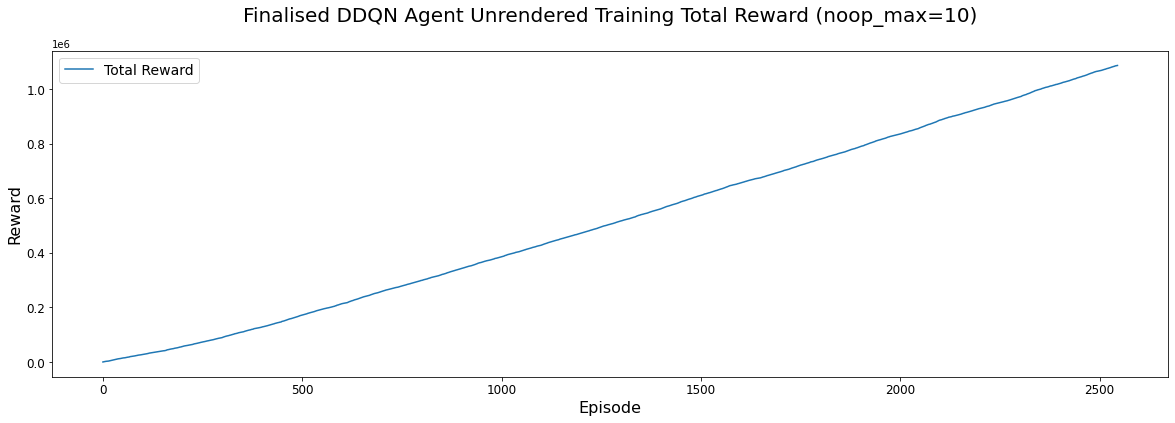

In [21]:
# Plot the training reward cumulative sum throughout the episodes (1 episode = 3 player lives)
plot_df(train_df, cols=['Total Reward'], x_label='Episode', y_label='Reward',\
        title='Finalised DDQN Agent Unrendered Training Total Reward (noop_max=10)\n')

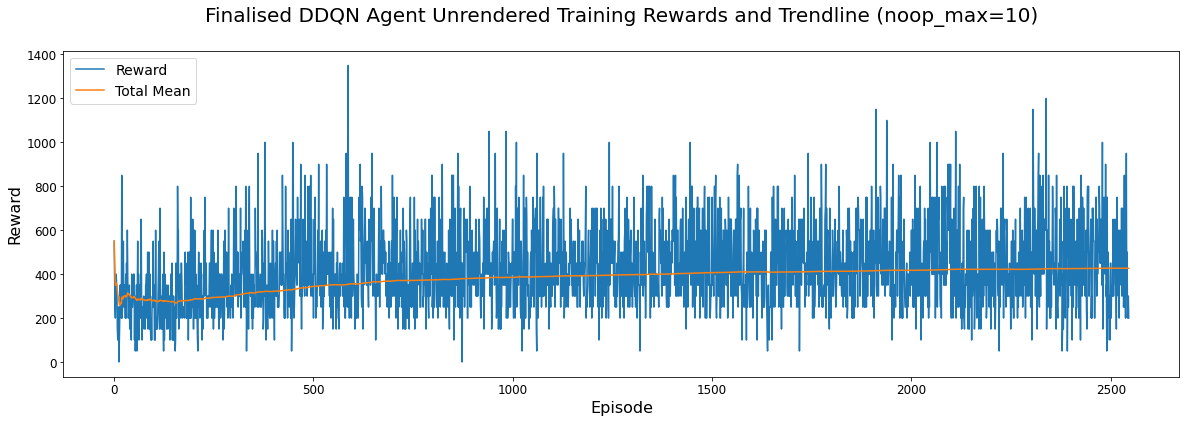

In [25]:
# Plot the training reward values throughout the episodes (1 episode = 3 player lives)
plot_df(train_df, cols=['Reward', 'Total Mean'], x_label='Episode', y_label='Reward',\
        title='Finalised DDQN Agent Unrendered Training Rewards and Trendline (noop_max=10)\n')

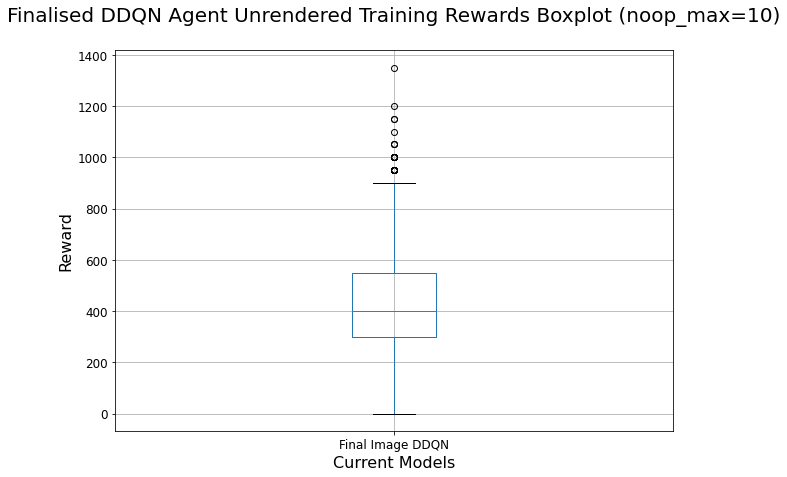

In [23]:
# Display a boxplot of the DDQN agent training data (agent rewards)
plot_boxplot(train_df, ['Reward'], ['Final Image DDQN'], x_label='Current Models', y_label='Reward',\
             title='Finalised DDQN Agent Unrendered Training Rewards Boxplot (noop_max=10)\n')

In [18]:
# Save the obtaine DDQN training data to a CSV file
train_df.to_csv('image_ddqn_final_unrendered_noop.csv')

In [19]:
# Create a HDF5 file with the trained online model
# with all the details necessary to reconstitute it. 
ddqn_online = ddqn_agent.online
ddqn_online.save('image_ddqn_online_final_unrendered_noop.h5') 

# Create a HDF5 file with the trained target model
# with all the details necessary to reconstitute it. 
ddqn_target = ddqn_agent.target
ddqn_target.save('image_ddqn_target_final_unrendered_noop.h5')  